# Analyza nejistot minimalizace EMM

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

Nejprve načtu histogramy odpovídající jednotlivým měřením

In [130]:
import numpy as np


fotkor_z = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,1]
voltages_z = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")[1,:]
fotkor_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,5]
voltages_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")[5,:]

# pomocne promene
fotkor_z_shape = np.shape(fotkor_z)
fotkor_xz_shape = np.shape(fotkor_xz)
# dale predpokladam, ze signaly maji stejny pocet binu
# fotkor_shape = np.array( [fotkor_z_shape, fotkor_xz_shape] )

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale_z = np.array( range(0,fotkor_z_shape[0]) ) *t_res
t_scale_xz = np.array( range(0,fotkor_xz_shape[0]) ) *t_res

t_scale = t_scale_z


#---------- odecet pozadi
# spolecne vsem merenim
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
#

last_bin_ratio_z = fotkor_z[fotkor_z_shape[0]-2] / fotkor_z[fotkor_z_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_z = bg_ph_sum/(fotkor_z_shape[0]-2 + last_bin_ratio_z)
last_bin_ratio_xz = fotkor_xz[fotkor_xz_shape[0]-2] / fotkor_xz[fotkor_xz_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_xz = bg_ph_sum/(fotkor_xz_shape[0]-2 + last_bin_ratio_xz)

fotkor_z[:fotkor_z_shape[0]-2] = fotkor_z[:fotkor_z_shape[0]-2] - bg_ph_per_bin_z 
fotkor_z[fotkor_z_shape[0]-2] = fotkor_z[fotkor_z_shape[0]-2] - bg_ph_per_bin_z * last_bin_ratio_z
fotkor_xz[:fotkor_xz_shape[0]-2] = fotkor_xz[:fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz 
fotkor_xz[fotkor_xz_shape[0]-2] = fotkor_xz[fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz * last_bin_ratio_xz
# ------------------------------

# vlozim signaly a voltage do matic
fotkor = np.transpose( np.array( [fotkor_z, fotkor_xz] ) ) # tvar: [data, osa]
voltages = np.transpose( np.array( [voltages_z, voltages_xz] ) ) # tvar: [data, osa]

fotkor_shape = np.shape(fotkor)

In [131]:
# odhad periody triggeru
Omega = np.zeros(fotkor_shape[1])
Omega_sigma = np.zeros(fotkor_shape[1])

for i in range(fotkor_shape[1]):
    T_trig = ( fotkor[fotkor_shape[0]-2,i] / fotkor[fotkor_shape[0]-3,i] )* t_res + t_scale[fotkor_shape[0]-2]
    T_trig_sigma = t_res
    # frekvence buzeni pasti

    drive_freq = 1/T_trig
    drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
    Omega[i] = 2*np.pi * drive_freq
    Omega_sigma[i] = 2*np.pi * drive_freq_sigma
    print(drive_freq)
    
Omega = np.mean(Omega)
Omega_sigma = np.sqrt(0.5*np.sum(Omega_sigma**2) )

print(Omega/(2*np.pi))
print(Omega_sigma/(2*np.pi))

30032035.976450287
30032822.857731443
30032429.417090867
230898.38519217444


Fitovani histogramu

In [132]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [133]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

hist_sigma = 100
W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/30**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )

In [137]:
DeltaS_S_ratio
fot_phi

[-1.4275464849099198, 1.3412538190451455]

vizualni kontrola

In [81]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

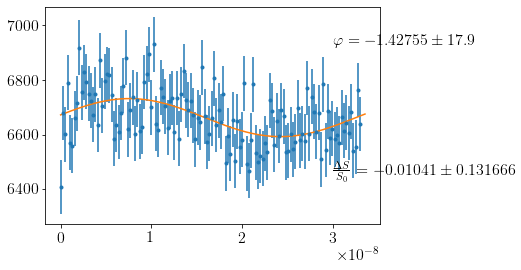

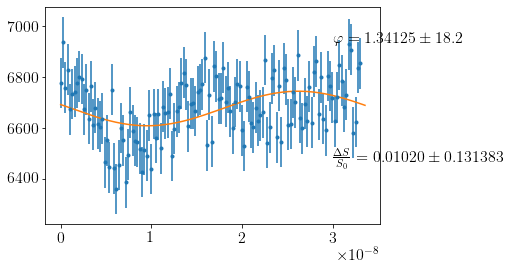

In [82]:
# plot fitu vcetne errorbaru
# my_dpi = 150
# siz = 100
# sizex = 16*siz
# sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure()
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],yerr=1/np.sqrt(W_vec),fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(x[1,i]/x[0,i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor[:,i].max()-500,text) 
    text2 = r'$\varphi  = {:.5f} \pm {:.3}$'.format(fot_phi[i], sigmas[2,i])
    plt.text(3e-8, fotkor[:,i].max(),text2) 


Vysledky nesedi s random gener testem. Zjistuju, ze bych mel k fitu pouzit metodu maximalizace Likehood funkce.

## Max. likehood test

In [98]:
def likehood(x, Omega, S, time_step, sigma):
    # definuju funkci vracejici logaritmus pravdepodobnosti, ze z distrubuce dane sinusovkou, co fituji vyberu pozorovane body
    # predpokladam, ze kazdy bod je normalne rozdelen kolem sinusovky
    
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    
    sum_term = ( (S - S_fit )/sigma )**2
    log_term = np.log( np.ones(len_S) * sigma * np.sqrt(2*np.pi) )
    
    return( 0.5* np.sum( sum_term ) + np.sum(log_term) ) # vraci - log( likehood)

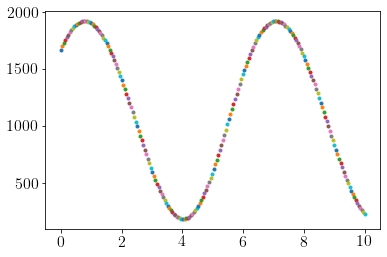

In [120]:
t = np.linspace(0, 10, 200)
S = 1 + 3*np.cos(t + 4)
t_step = 10/200

x1 = np.linspace(0,10,200)

plt.figure()
for i in range(200):
    plt.plot(x1[i], likehood([1,3,x1[i]], 1, S, t_step, 1), '.')
# likehood([0,3,0], 40, [1,2,1,2,1,2], 0.5, 100)

likehood fce vypada ok. zkusim minimalizovat

In [146]:
# minimalizace likehood

from scipy.optimize import minimize

hist_sigma = 100
x0 = [fotkor[:fotkor_shape[0]-2,1].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,1].max()
    -fotkor[:fotkor_shape[0]-2,1].min() ), 1.5]
    
fit = minimize(likehood, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,1], t_res, hist_sigma )  )

DeltaS_S_ratio_likehood = fit.x[1]/fit.x[0]

test vypada ok

In [158]:
x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

hist_sigma = 10
# W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/30**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
#     fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    fit = minimize(likehood, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma ), tol=1e-10)
    #---- odhad nejistot parametru----
#     jac = fit.jac
    C = fit.hess_inv  # variancni-kovariancni matice
#     resid_sq = fit.fun**2   # residua na druhou
#     g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )

In [159]:
DeltaS_S_ratio

[0.01041243545040437, 0.01019762959014562]

In [160]:
fot_phi

[-1.4275465094094686, 1.3412537614193696]

In [161]:
Delta_S_S_ratio_sigma

[0.0007451500361287608, 9.828957747668253e-05]

vypada, ze odhad nejistot funguje!!